This notebook will load OpenCV sample images from the camera calibration (chessboard images) and project 3dimensional objects on the image plane.
The code is based on the example from [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html#pose-estimation)

In [ ]:
#@title
# load pictures from github repository to colab
#
# 
# files: left01.jpg ... left09.jpg + left11.jpg...left14.jpg
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left01.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left02.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left03.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left04.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left05.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left06.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left07.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left08.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left09.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left11.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left12.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left13.jpg
#
!curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://raw.githubusercontent.com/iubh/DLMAIEAIS01_DEV/master/data/cv_pictures/left14.jpg
#

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27908  100 27908    0     0  55704      0 --:--:-- --:--:-- --:--:-- 55593
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28611  100 28611    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29553  100 29553    0     0   118k      0 --:--:-- --:--:-- --:--:--  118k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25150  100 25150    0     0  99015      0 --:--:-- --:--:-- --:--:-- 98627
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
import cv2
import numpy as np
import glob

# Load previously camera calibration matrix
#
# the data come from the camera calibration tutorial (cv_3-4_camera_calibration.ipynb)
#
mtx = np.array(
    [
     [458.64099121,   0.0,         343.09157581],
     [  0.0,         457.19467163, 233.83376475],
     [  0.0,           0.0,           1.0]
    ]
    )
#
dist = np.array([-2.92971621e-01,  1.07706887e-01,  1.31038490e-03, -3.11022978e-05,   4.34799142e-02])
#
#with np.load('B.npz') as X:
#    mtx, dist, _, _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

the function, ``draw`` takes the corners in the chessboard (obtained using ``cv2.findChessboardCorners()``) and **axis points** to draw a 3D axis.

In [ ]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

Then as in previous case, we create termination criteria, object points (3D points of corners in chessboard) and axis points. Axis points are points in 3D space for drawing the axis. We draw axis of length 3 (units will be in terms of chess square size since we calibrated based on that size). So our X axis is drawn from (0,0,0) to (3,0,0), so for Y axis. For Z axis, it is drawn from (0,0,0) to (0,0,-3). Negative denotes it is drawn towards the camera.

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

Now, as usual, we load each image. Search for 7x6 grid. If found, we refine it with subcorner pixels. Then to calculate the rotation and translation, we use the function, ``cv2.solvePnPRansac()``.
With the transformation matrices the axis points can be projected to the image plane.
In simple words, we find the points on image plane corresponding to each of (3,0,0),(0,3,0),(0,0,3) in 3D space. Once we get them, we draw lines from the first corner to each of these points using our draw() function.

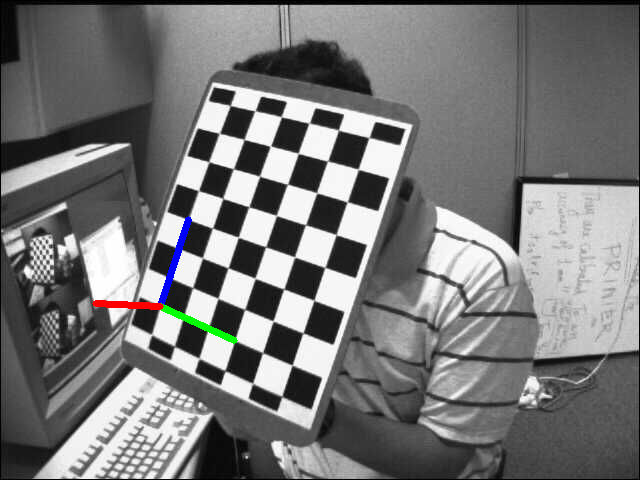

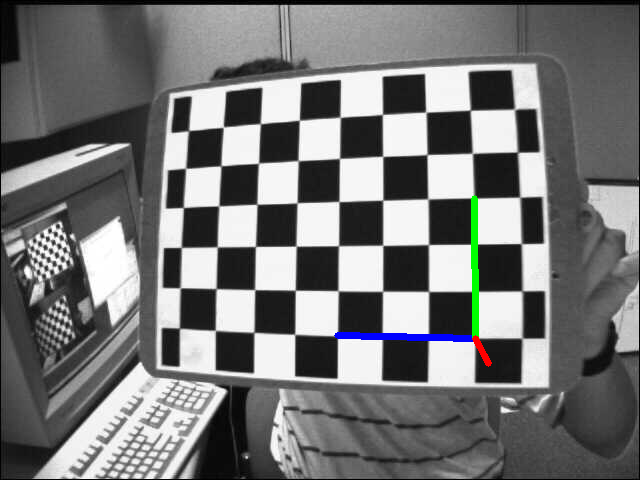

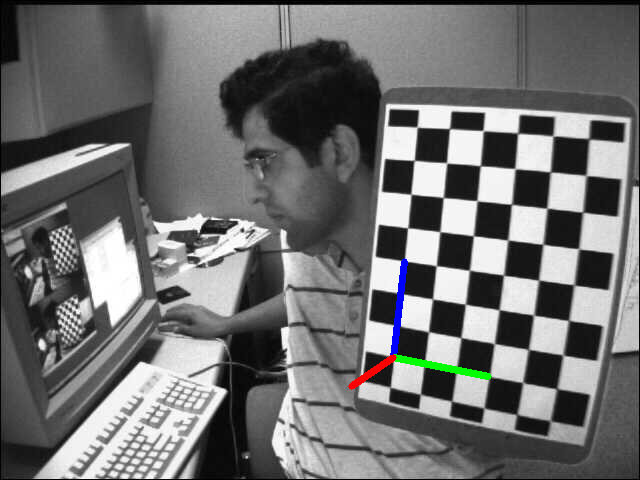

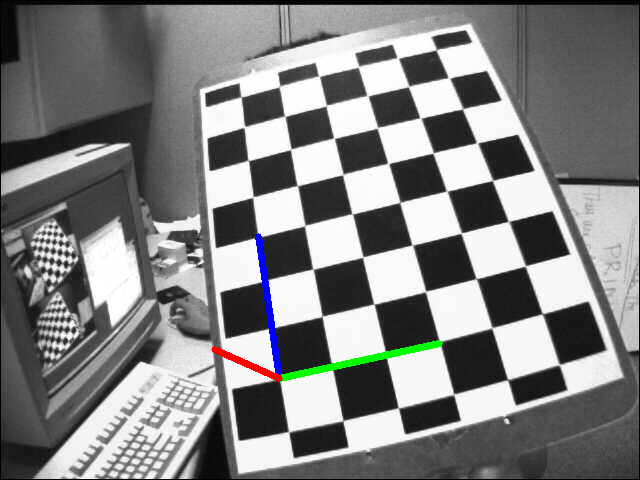

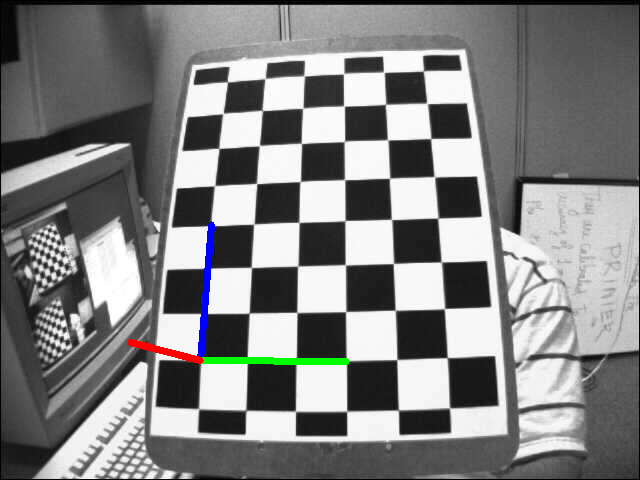

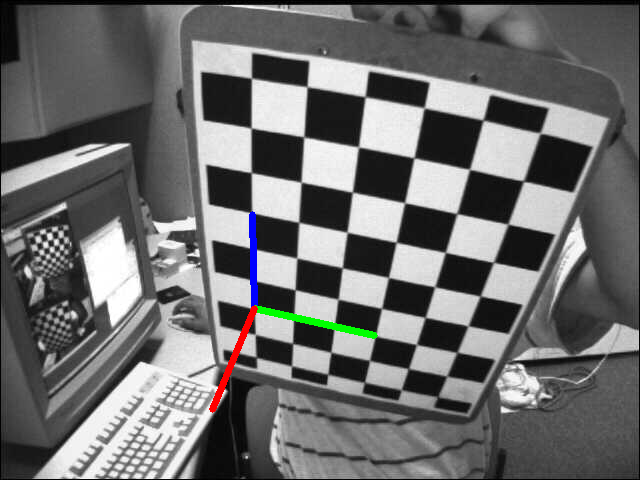

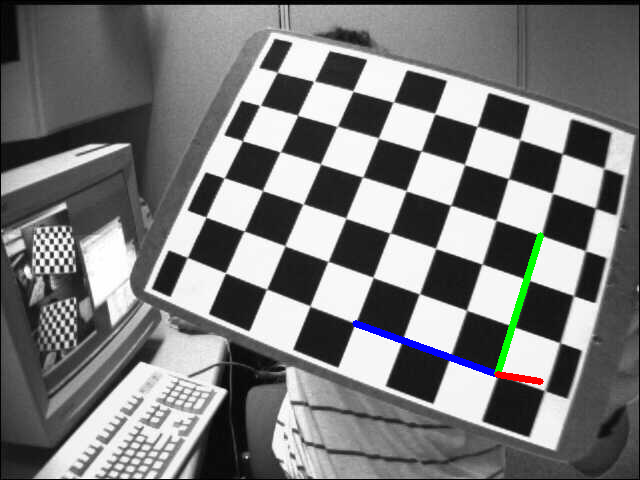

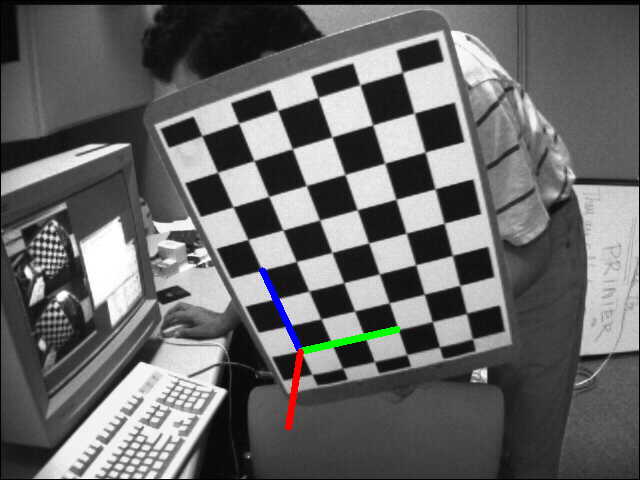

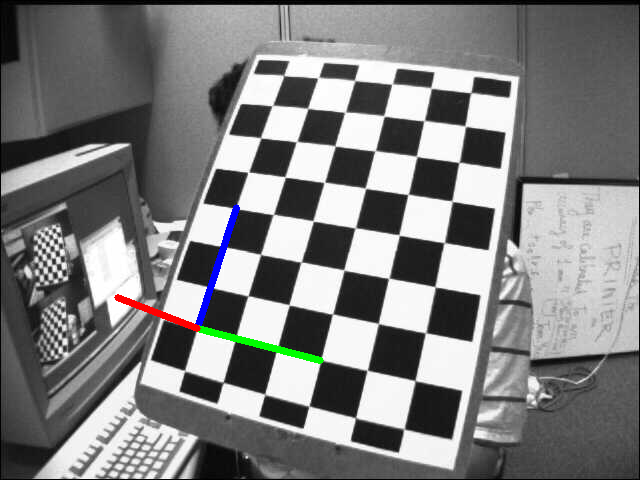

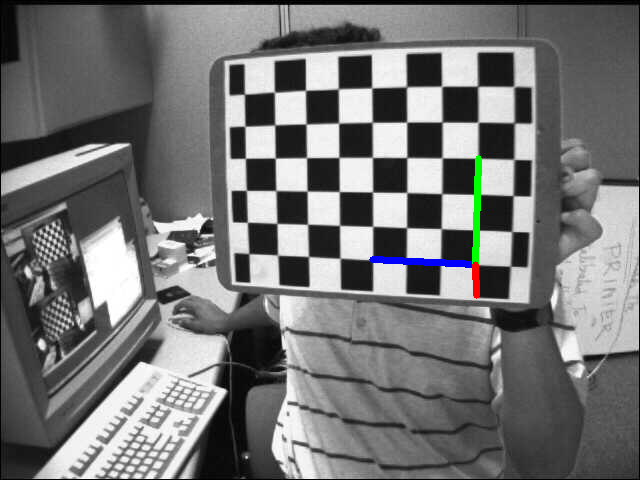

In [ ]:
from google.colab.patches import cv2_imshow  # a replacement for the cv2.imshow() function to use in jupyter-notebooks
#
for fname in glob.glob('left*.jpg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        img = draw(img,corners2,imgpts)
        # cv2.imshow('img',img)
        cv2_imshow(img)
        k = cv2.waitKey(0) & 0xff
        if k == 's':
            cv2.imwrite(fname[:6]+'.png', img)

cv2.destroyAllWindows()

# Render Cube on image

to draw a cube on the image plane the ``draw()`` function is modified as follows:

In [ ]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img

Modified axis points. They are the 8 corners of a cube in 3D space:

In [ ]:
axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])

Draw cubes:

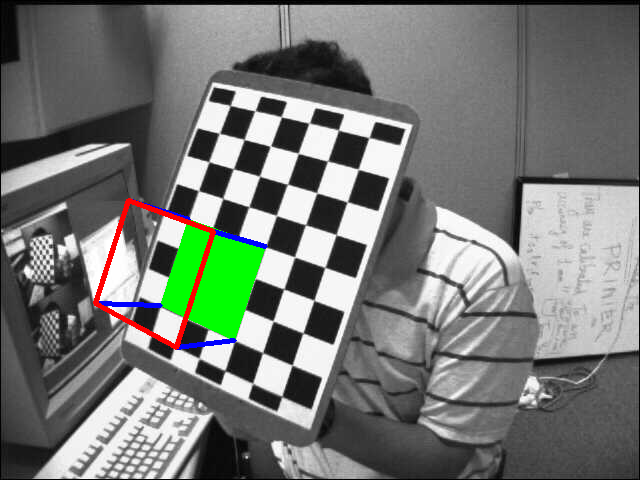

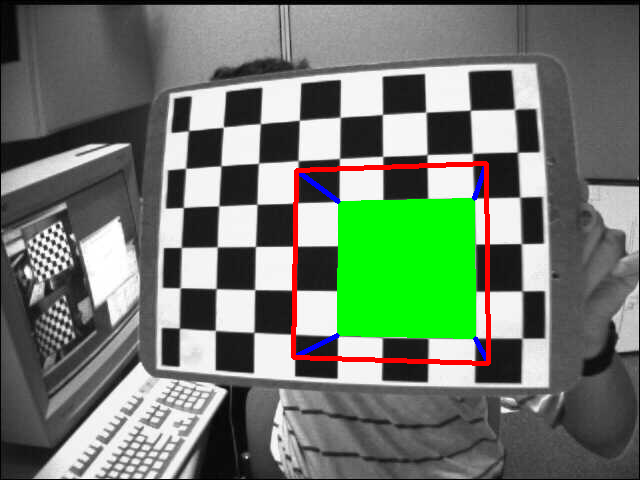

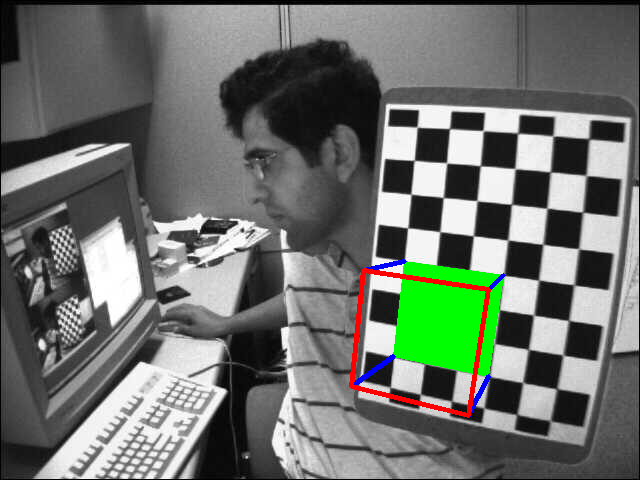

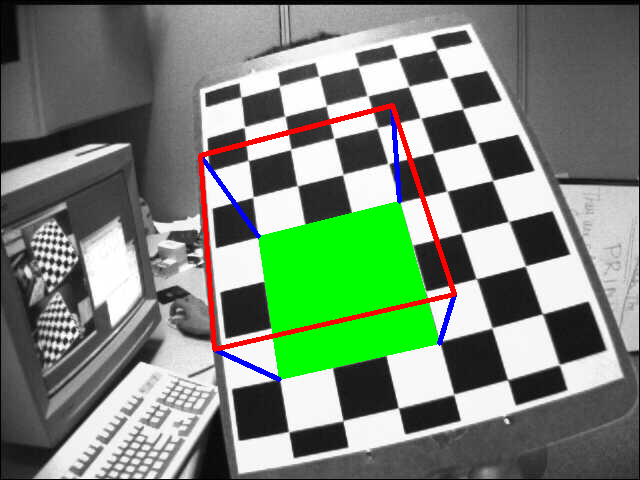

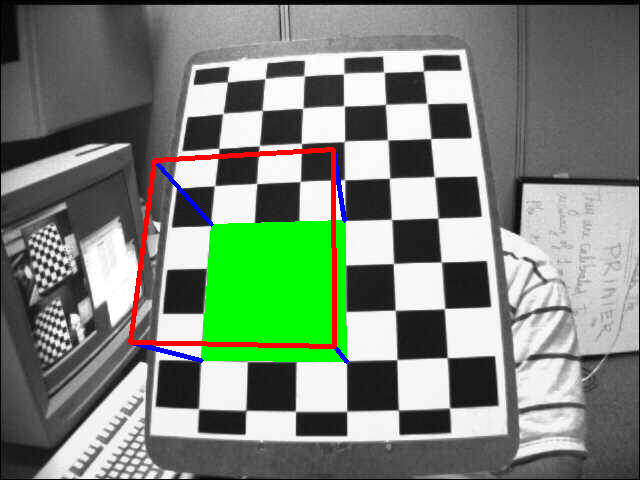

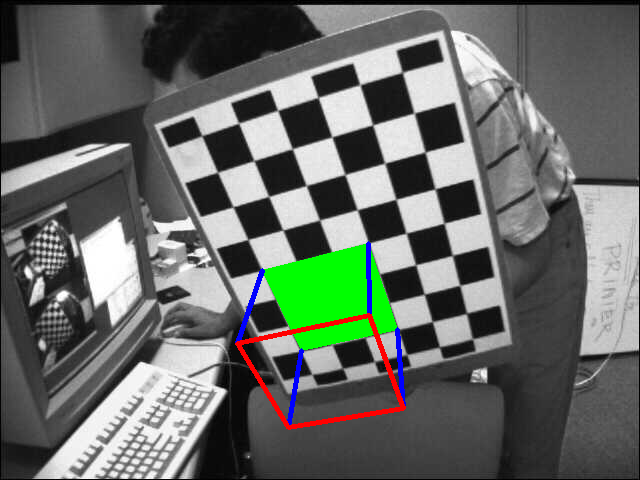

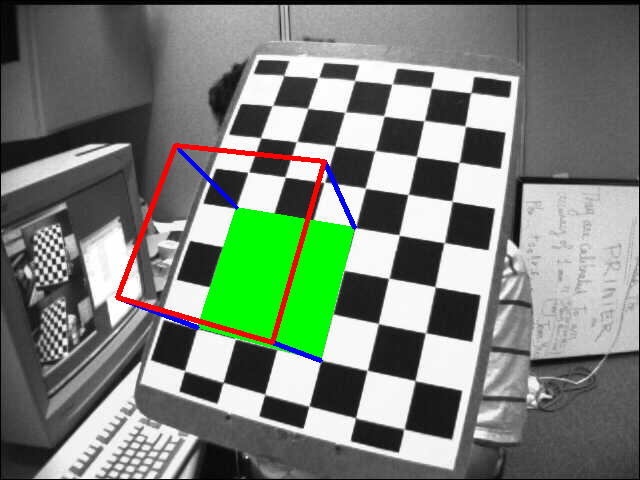

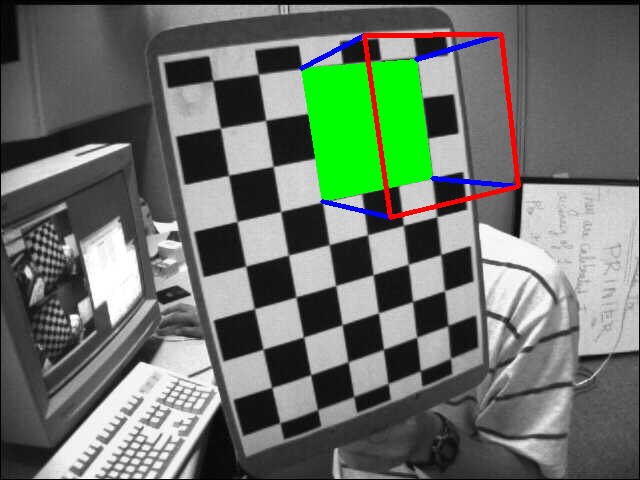

In [ ]:
for fname in glob.glob('left*.jpg'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        img = draw(img,corners2,imgpts)
        # cv2.imshow('img',img)
        cv2_imshow(img)
        k = cv2.waitKey(0) & 0xff
        if k == 's':
            cv2.imwrite(fname[:6]+'.png', img)

cv2.destroyAllWindows()